In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz

import sys
sys.path.append("../src")

import preprocess_data

https://tobykingsman.wordpress.com/2016/05/26/extended-bradley-terry-models/
http://rstudio-pubs-static.s3.amazonaws.com/464536_3fd62ecc2cd64e6a9052a738d5449809.html
https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/

In [2]:
def player_games_mask(df, player_id):
    return (df["white_id"] == player_id) | (df["black_id"] == player_id)

In [3]:
train = preprocess_data.create_train_data()
num_players = len(set(train["white_id"].values).union(set(train["black_id"].values)))
num_games = len(train)

In [4]:
raw_prior_score = np.arange(num_players, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (2 * np.std(raw_prior_score, ddof=1))

In [5]:
white_outcome = {"white": 3, "draw": 2, "black": 1}
train["white_outcome"] = train["outcome"].apply(lambda x: white_outcome[x])

In [6]:
train_sorted = train.sort_values(["abs_rank_diff", "white_id"], ascending=[False, True])

### Set-up model

In [7]:
ordered_model = pystan.StanModel("../stan_models/ordered_logistic.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c496099c18b1643b662a368d055d6469 NOW.


In [23]:
stan_data_ordered = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "fave_rank": train_sorted["white_prior_rank"].values.astype(int),
    "underdog_rank": train_sorted["black_prior_rank"].values.astype(int),
    "y": train_sorted["white_outcome"].values.astype(int),
    #"white_is_fave": train_sorted["white_is_fave"].values.astype(int)
}

In [24]:
ordered_fit = ordered_model.sampling(data=stan_data_ordered)

In [26]:
ordered_params = ordered_fit.extract(permuted=True)

ordered_inference_data = arviz.convert_to_inference_data(ordered_fit)
ordered_summary_df = arviz.summary(ordered_inference_data).reset_index().rename(columns={"index":"parameter"})

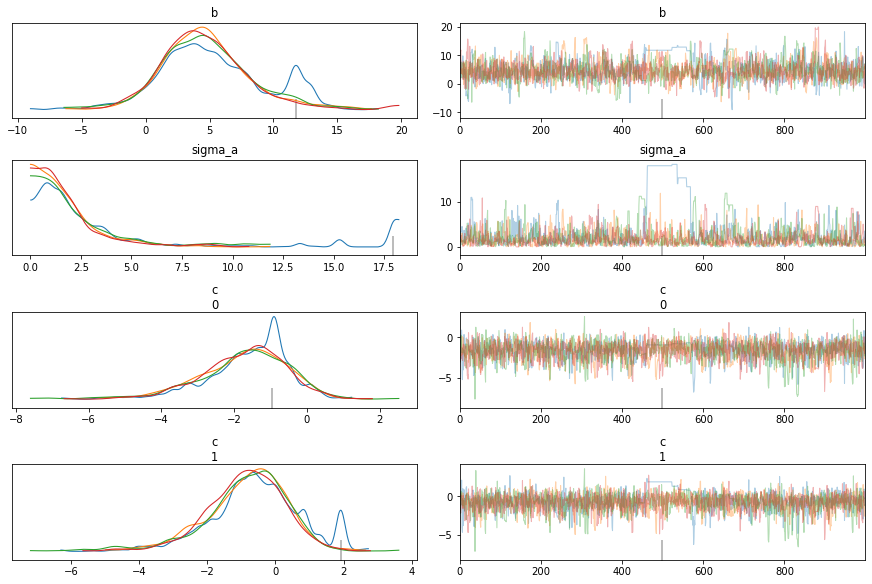

In [27]:
arviz.plot_trace(ordered_inference_data, var_names=["b", "sigma_a", "c"]);

### Plotting

In [28]:
underdog_ranks = train.groupby("underdog_id")["underdog_rank"].mean().sort_values().to_dict()
fave_ranks = train.groupby("fave_id")["fave_rank"].mean().sort_values().to_dict()
all_ranks = {**fave_ranks, **underdog_ranks}
all_rank_ids = np.array(list(all_ranks.keys())).astype(int)

IndexError: index 6 is out of bounds for axis 1 with size 6

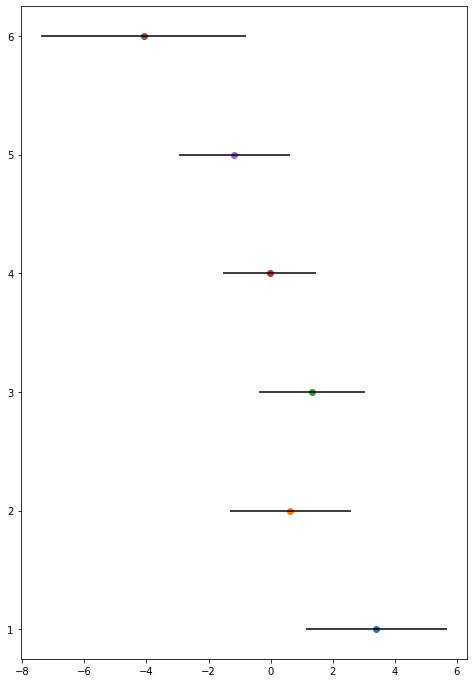

In [29]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 25

for i in range(plot_top_n_players):
    a_mean = ordered_params["a"][:, i].mean()
    a_sd = float(ordered_summary_df.loc[ordered_summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)
    
plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5);
plt.gca().invert_yaxis();
plt.suptitle(f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]");
plt.yticks(range(1, plot_top_n_players + 1), all_rank_ids[:plot_top_n_players]);

In [15]:
train.loc[player_games_mask(train, 1503014)].head(25)

,date,round,white_id,black_id,white_elo,black_elo,white_title,black_title,result,year,...,underdog_id,fave_rank,underdog_rank,fave_score,underdog_score,fave_outcome,white_is_fave,abs_rank_diff,fave_underdog_score_diff,white_outcome
435,2017-09-03,1.1,1503014,8501246,2827.0,2255.0,GM,FM,1-0,2017,...,8501246.0,1.0,283.0,1.0,0.0,3,1,282,1.0,3
499,2017-09-04,1.2,8501246,1503014,2255.0,2827.0,FM,GM,0-1,2017,...,8501246.0,1.0,283.0,1.0,0.0,3,0,282,1.0,1
627,2017-09-06,2.1,4100107,1503014,2648.0,2827.0,GM,GM,0-1,2017,...,4100107.0,1.0,92.0,1.0,0.0,3,0,91,1.0,1
659,2017-09-07,2.2,1503014,4100107,2827.0,2648.0,GM,GM,1-0,2017,...,4100107.0,1.0,92.0,1.0,0.0,3,1,91,1.0,3
755,2017-09-09,3.1,1503014,8601445,2827.0,2714.0,GM,GM,0-1,2017,...,8601445.0,1.0,57.0,0.0,1.0,1,1,56,-1.0,1
771,2017-09-10,3.2,8601445,1503014,2714.0,2827.0,GM,GM,1/2-1/2,2017,...,8601445.0,1.0,57.0,0.5,0.5,2,0,56,0.0,2


#### Look at some outcomes for games
* 3 means the favourite won.
* 2 is a draw
* 1 is the underdog won.

In [16]:
levels = [1, 2, 3]
out = []
for l in levels:
    out.append(np.sum(ordered_params["ypred"] == l, 0))
out = np.array(out).T
out_prob = out/np.mean(out.sum(1))

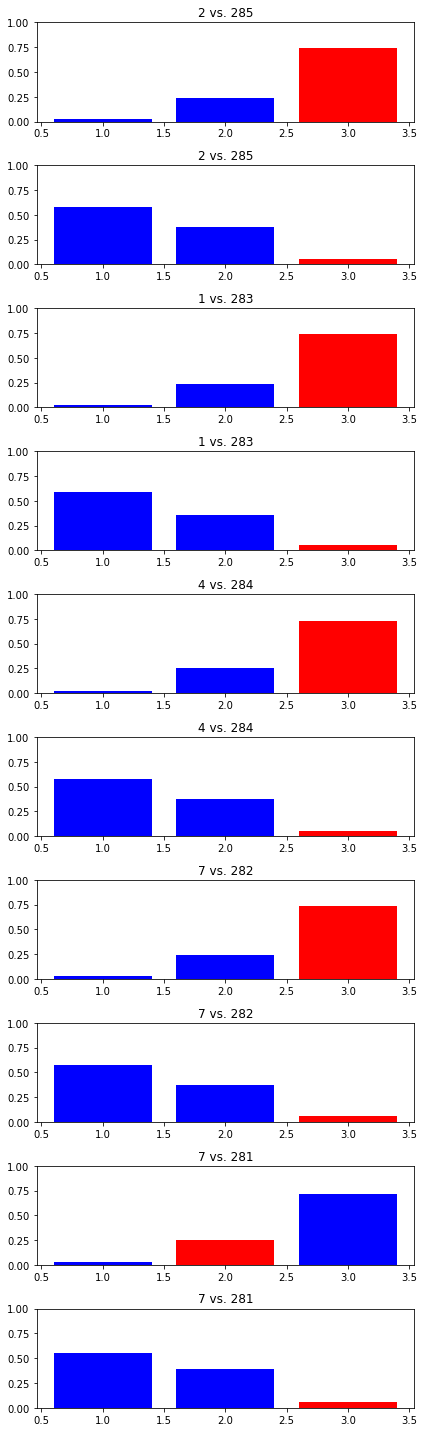

In [17]:
plot_n = 10
reverse = False
colors = ["blue"]*3

plot_df = train_sorted if not reverse else train_sorted.sort_values(["abs_rank_diff", "fave_id"], ascending=[True, False])
ranks = [f"{a} vs. {b}" for a, b in zip(train_sorted["fave_rank"].values.astype(int), train_sorted["underdog_rank"].values.astype(int))]

fig, ax = plt.subplots(plot_n, 1, figsize=(6, 20))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[train_sorted["fave_outcome"].values[i] - 1] = "red"
    ax[i].bar(range(1, 4), out_prob[i, :], color=bar_colors);
    ax[i].set_title(f"{ranks[i]}");
    ax[i].set_ylim(0, 1);
plt.tight_layout();

In [21]:
cls_pred = np.argmax(out_prob, 1) + 1

In [22]:
np.mean(np.abs(train_sorted["fave_outcome"] - cls_pred) == 0)

0.5524599881446355

In [23]:
np.mean(np.abs(train_sorted["fave_outcome"] - cls_pred) == 1)

0.43924125666864255

In [24]:
np.mean(np.abs(train_sorted["fave_outcome"] - cls_pred) == 2)

0.008298755186721992